# Create the wake file

In [1]:
import netCDF4 as nc
import numpy as np
from datetime import datetime, timedelta
import math
import sys

import matplotlib.pyplot as plt

In [2]:
# Define height values
height_surf_values   = [4]

height_lidar_values  = np.arange(40, 410, 10)
height_assist_values = np.array([0, 10, 21, 33, 46, 61, 77, 95, 114, 136, 159, 185, 214, 245, 280, 318, 
                                 359, 405, 456, 512, 573, 640, 714, 795, 885, 983, 1092, 1211, 1342, 1486, 
                                 1645, 1819, 2011, 2223, 2455, 2710, 2991, 3300, 3640, 4014])

height_lidar_length = len(height_lidar_values)
height_assist_length = len(height_assist_values)

In [3]:
print(height_assist_length)

40


In [4]:
# Define height values
x_nacelle_lidar_values = np.arange(0, 4001, 127)
y_nacelle_lidar_values = np.arange(-2540, 2540, 127)
x_nacelle_lidar_length = len(x_nacelle_lidar_values)
y_nacelle_lidar_length = len(y_nacelle_lidar_values)

In [5]:
# See https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console                                                                   
def progress(count, total, suffix=''):
    """                                                                                                                                              
    print out a progressbar                                                                                                                          
    """
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))
    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)
    sys.stdout.write('[%s] %s%s %s\r' % (bar, percents, '%', suffix))
    sys.stdout.flush()

In [6]:
def concatLidarNC(ncfilelist, group, varlist, dims=1):
    timearr = None
    datadict = {}
    for f in ncfilelist:
        print(f)
        ds = nc.Dataset(f, "r")
        #print(ds[group])
        if timearr is None:
            timearr = ds['time']
            datadict['coordinates'] = ds[group]['coordinates']
            for v in varlist:
                datadict[v] = ds[group][v]
        else:
            time = ds['time']
            lasttime = timearr[-1]
            mask = (time>lasttime)
            timearr = np.append(timearr, time[mask])
            for v in varlist:
                if dims==1:
                    datadict[v] = np.append(datadict[v], ds[group][v][mask, :], axis=0)
                else:
                    datadict[v] = np.append(datadict[v], ds[group][v][mask, :, :], axis=0)
    #print(len(timearr))
    datadict['time'] = timearr
    return datadict

def pullsubset(data, varlist, newz, verbose=False):
    # Assumes newz is exactly in the coordinates
    newdat = {}
    newdat['time'] = data['time']
    coords = data['coordinates']
    oldz   = coords[:,2]
    mask   = np.isin(oldz,newz)
    if verbose:
        print(mask)
    newcoords = coords[mask, :]
    newdat['coordinates'] = newcoords
    for v in varlist:
        newdat[v] = data[v][:, mask]
    #print(newcoords)
    return newdat

def interpsubset(data, varlist, newz):
    newdat = {}
    newdat['time'] = data['time']
    coords = data['coordinates']
    oldz   = coords[:,2]
    # Create the new coordinates
    newcoords = []
    oldx, oldy = coords[0,0], coords[0,1]
    #print(oldx, oldy)
    for z in newz:
        newcoords.append([oldx, oldy, z])
    newdat['coordinates'] = np.array(newcoords)
    # Interp the variables to the newz
    for v in varlist:
        newvar = np.zeros((len(newdat['time']), len(newz)))
        for it, t in enumerate(newdat['time']):
            newvar[it, :] = np.interp(newz, oldz, data[v][it,:], right=np.nan)
        newdat[v] = newvar
    return newdat

def calc_WS_WD(d):
    d['WS'] = np.sqrt(d['velocityx']**2 + d['velocityy']**2)
    d['WD'] = 270-np.arctan2(d['velocityy'], d['velocityx'])*180.0/math.pi

def downsample_dict(d, ds, varlist):
    d['time_ds'] = d['time'][::ds]
    for v in varlist:
        d[v+'_ds'] = d[v][::ds]
    return

def getWakeVars(d, coordoffset, N1, Nx, Ny, wakevars = ['WS', 'WD'], ds=10, verbose=True):
    Ntime = len(d['time'])
    #print(Ntime)
    newcoords = d['coordinates'][:,:]-coordoffset
    mask = np.array([False]*len(newcoords))
    for i in range(y_nacelle_lidar_length):
        mask[(ds*i*N1):((ds*i+1)*N1):10] = True
    subsetcoord = newcoords[mask]
    #print(subsetcoord)
    reordercoord = []
    for i in range(Nx):
        for j in range(Ny):
            reordercoord.append(subsetcoord[j*Nx+i])
    reordercoord = np.array(reordercoord)
    d['coord_arr'] = reordercoord
    #print(reordercoord)
    for v in wakevars:
        if verbose: print(v)
        d[v+'_arr'] = np.zeros((Ntime, Nx, Ny))
        for ti in range(Ntime):
            if verbose: progress(ti+1, Ntime)
            for i in range(Nx):
                for j in range(Ny):
                    d[v+'_arr'][ti][i][j] = d[v][ti][j*Nx+i]
        if verbose: print()
    return

## Get lidar and assist variables

In [7]:
rundir = '/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing'
#'/lustre/orion/cfd162/world-shared/lcheung/AWAKEN.cli187/Benchmark1/Phase1/BM1_FarmRunProd1.summit/post_processing'
grouplist = ['lidar_siteA1', 'lidar_siteA2', 'lidar_siteB', 'lidar_siteE36', 'lidar_siteC1a', 'lidar_siteH', 'lidar_siteG', 'lidar_siteGC']
lidargroups  = ['lidar_siteC1a', 'lidar_siteH', 'lidar_siteGC', ]
assistgroups = ['lidar_siteH', 'lidar_siteC1a', 'lidar_siteG', 'lidar_siteGC']
ds           = 10 # Downsample frequency

In [8]:
filelist = [rundir+'/lidar_48000.nc', rundir+'/lidar_68000.nc']
lidarvarlist  = ['velocityx', 'velocityy', 'velocityz', 'tke']
assistvarlist = ['temperature']

In [9]:
lidardat = {}
for group in lidargroups:
    print(group)
    d = concatLidarNC(filelist, group, lidarvarlist)
    newd = pullsubset(d, lidarvarlist, height_lidar_values)
    calc_WS_WD(newd)
    downsample_dict(newd, ds, lidarvarlist+['WS', 'WD'])
    lidardat[group] = newd

lidar_siteC1a
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/lidar_48000.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/lidar_68000.nc
lidar_siteH
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/lidar_48000.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/lidar_68000.nc
lidar_siteGC
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/lidar_48000.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/lidar_68000.nc


In [10]:
# Get the assist data
assistdat={}
for group in assistgroups:
    print(group)
    d = concatLidarNC(filelist, group, assistvarlist)
    interpd = interpsubset(d, assistvarlist, height_assist_values)
    downsample_dict(interpd, ds, assistvarlist)
    assistdat[group] = interpd

lidar_siteH
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/lidar_48000.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/lidar_68000.nc
lidar_siteC1a
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/lidar_48000.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/lidar_68000.nc
lidar_siteG
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/lidar_48000.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/lidar_68000.nc
lidar_siteGC
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/lidar_48000.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/lidar_68000.nc


```python
filelist = [rundir+'/lidar_48000.nc', rundir+'/lidar_68000.nc']
group    = 'lidar_siteGC'
allvarlist  = ['velocityx', 'velocityy', 'velocityz', 'temperature']
varlist  = ['velocityx', 'velocityy', 'velocityz',]
d = concatLidarNC(filelist, group, allvarlist)
newd    = pullsubset(d, varlist, height_lidar_values)
interpd = interpsubset(d, ['temperature'], height_assist_values)
```

## Get surface data variables

In [11]:
surffilelist = [rundir+'/surf_48000.nc', rundir+'/surf_68000.nc']
surfgroups   = [ 'surface_siteC1a',  'surface_siteG', 'surface_siteH']
surfvarlist  = ['velocityx', 'velocityy', 'velocityz', 'tke', 'temperature']

In [12]:
# Get the surface data
surfdat={}
for group in surfgroups:
    print(group)
    d = concatLidarNC(surffilelist, group, surfvarlist)
    newd = pullsubset(d, surfvarlist, height_surf_values)
    calc_WS_WD(newd)
    downsample_dict(newd, ds, surfvarlist+['WS','WD'])
    surfdat[group] = newd

surface_siteC1a
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/surf_48000.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/surf_68000.nc
surface_siteG
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/surf_48000.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/surf_68000.nc
surface_siteH
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/surf_48000.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/surf_68000.nc


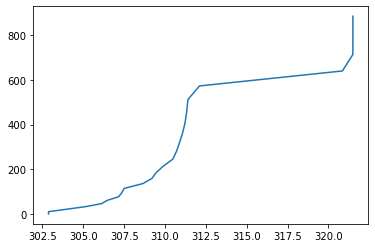

In [13]:
plt.plot(assistdat['lidar_siteH']['temperature'][-1,:] ,assistdat['lidar_siteH']['coordinates'][:,2])

```python
filelist = [rundir+'/E06wake_z122_48000.nc', rundir+'/E06wake_z122_68000.nc']
group    = 'Farm_E06wake122'
allvarlist  = ['velocityx', 'velocityy', 'velocityz', 'temperature']
varlist  = ['velocityx', 'velocityy', 'velocityz',]
d = concatLidarNC(filelist, group, varlist, dims=1)
calc_WS_WD(d)

coordoffset = np.array([640388.694095803, 4030719.63654416, 0]) + np.array([2540, 0, 0])
N1 = 316
getWakeVars(d, coordoffset, N1, len(x_nacelle_lidar_values), len(y_nacelle_lidar_values), wakevars = ['WS', 'WD'], ds=10, verbose=True)
```

## Extract wake quantities

In [14]:
zheights = ['27','59','90','122','154','217','281','344']
fileiters = [48000, 68000]
varlist  = ['velocityx', 'velocityy', 'velocityz',]

coordoffset = np.array([640388.694095803, 4030719.63654416, 0]) + np.array([2540, 0, 0])
N1 = 316

E06wake = {}
for z in zheights:
    filelist = [rundir+'/E06wake_z%s_%i.nc'%(z, i) for i in fileiters]
    group    = 'Farm_E06wake%s'%z
    d = concatLidarNC(filelist, group, varlist, dims=1)
    calc_WS_WD(d)
    getWakeVars(d, coordoffset, N1, len(x_nacelle_lidar_values), len(y_nacelle_lidar_values), wakevars = ['WS', 'WD'], ds=10, verbose=True)
    E06wake[z] = d

/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/E06wake_z27_48000.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/E06wake_z27_68000.nc
WS
[============================================================] 100.0% 
WD
[============================================================] 100.0% 
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/E06wake_z59_48000.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/E06wake_z59_68000.nc
WS
[============================================================] 100.0% 
WD
[============================================================] 100.0% 
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/E06wake_z90_48000.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/E06wake_z90_68000.nc
WS
[==============================================

## Write out the netcdf file

In [15]:
time = surfdat['surface_siteC1a']['time_ds'][:]
# Define time values
#start_time = datetime(2023, 8, 24, 0, 0)
#time_values = [start_time + timedelta(seconds=time_resolution*i) for i in range(time_length)]
start_time = datetime(2023, 8, 23, 22, 15)  #This is the start time of the AMR-Wind simulation
#print(start_time+ timedelta(seconds=time[i])) #This is the first time step to be saved in the simulation
time_values = [start_time + timedelta(seconds=time[i]) for i in range(len(time))]
time_length = len(time_values)
print(time_length)

4000


In [16]:
# Create netCDF file
with nc.Dataset("template_wake.nc", "w") as f:
    # Create dimensions
    f.createDimension("time", time_length)
    f.createDimension("height_lidar", height_lidar_length)
    f.createDimension("height_assist", height_assist_length)
    f.createDimension("x_nacelle_lidar", x_nacelle_lidar_length)
    f.createDimension("y_nacelle_lidar", y_nacelle_lidar_length)
    
    # Create variables
    u_siteC1a = f.createVariable("u_siteC1a", "f4", ("time", "height_lidar"))
    u_siteH = f.createVariable("u_siteH", "f4", ("time", "height_lidar"))
    u_siteGC = f.createVariable("u_siteGC", "f4", ("time", "height_lidar"))
    v_siteC1a = f.createVariable("v_siteC1a", "f4", ("time", "height_lidar"))
    v_siteH = f.createVariable("v_siteH", "f4", ("time", "height_lidar"))
    v_siteGC = f.createVariable("v_siteGC", "f4", ("time", "height_lidar"))
    WS_siteC1a = f.createVariable("WS_siteC1a", "f4", ("time", "height_lidar"))
    WS_siteH = f.createVariable("WS_siteH", "f4", ("time", "height_lidar"))
    WS_siteGC = f.createVariable("WS_siteGC", "f4", ("time", "height_lidar"))
    w_siteC1a = f.createVariable("w_siteC1a", "f4", ("time", "height_lidar"))
    w_siteH = f.createVariable("w_siteH", "f4", ("time", "height_lidar"))
    w_siteGC = f.createVariable("w_siteGC", "f4", ("time", "height_lidar"))
    WD_siteC1a = f.createVariable("WD_siteC1a", "f4", ("time", "height_lidar"))
    WD_siteH = f.createVariable("WD_siteH", "f4", ("time", "height_lidar"))
    WD_siteGC = f.createVariable("WD_siteGC", "f4", ("time", "height_lidar"))
    TI_siteC1a = f.createVariable("TI_siteC1a", "f4", ("time", "height_lidar"))
    TI_siteH = f.createVariable("TI_siteH", "f4", ("time", "height_lidar"))
    TI_siteGC = f.createVariable("TI_siteGC", "f4", ("time", "height_lidar"))
    TKE_siteC1a = f.createVariable("TKE_siteC1a", "f4", ("time", "height_lidar"))
    TKE_siteH = f.createVariable("TKE_siteH", "f4", ("time", "height_lidar"))
    TKE_siteGC = f.createVariable("TKE_siteGC", "f4", ("time", "height_lidar"))
    # Temperature
    T_siteH = f.createVariable("T_siteH", "f4", ("time", "height_assist"))
    T_siteC1a = f.createVariable("T_siteC1a", "f4", ("time", "height_assist"))
    T_siteG = f.createVariable("T_siteG", "f4", ("time", "height_assist"))
    T_siteGC = f.createVariable("T_siteGC", "f4", ("time", "height_assist"))
    # Near-surface
    u_sfc_siteC1a = f.createVariable("u_sfc_siteC1a", "f4", ("time",))
    u_sfc_siteG = f.createVariable("u_sfc_siteG", "f4", ("time",))
    u_sfc_siteH = f.createVariable("u_sfc_siteH", "f4", ("time",))
    v_sfc_siteC1a = f.createVariable("v_sfc_siteC1a", "f4", ("time",))
    v_sfc_siteG = f.createVariable("v_sfc_siteG", "f4", ("time",))
    v_sfc_siteH = f.createVariable("v_sfc_siteH", "f4", ("time",))
    w_sfc_siteC1a = f.createVariable("w_sfc_siteC1a", "f4", ("time",))
    w_sfc_siteG = f.createVariable("w_sfc_siteG", "f4", ("time",))
    w_sfc_siteH = f.createVariable("w_sfc_siteH", "f4", ("time",))
    WS_sfc_siteC1a = f.createVariable("WS_sfc_siteC1a", "f4", ("time",))
    WS_sfc_siteG = f.createVariable("WS_sfc_siteG", "f4", ("time",))
    WS_sfc_siteH = f.createVariable("WS_sfc_siteH", "f4", ("time",))
    WD_sfc_siteC1a = f.createVariable("WD_sfc_siteC1a", "f4", ("time",))
    WD_sfc_siteG = f.createVariable("WD_sfc_siteG", "f4", ("time",))
    WD_sfc_siteH = f.createVariable("WD_sfc_siteH", "f4", ("time",))
    TI_sfc_siteC1a = f.createVariable("TI_sfc_siteC1a", "f4", ("time",))
    TI_sfc_siteG = f.createVariable("TI_sfc_siteG", "f4", ("time",))
    TI_sfc_siteH = f.createVariable("TI_sfc_siteH", "f4", ("time",))
    TKE_sfc_siteC1a = f.createVariable("TKE_sfc_siteC1a", "f4", ("time",))
    TKE_sfc_siteG = f.createVariable("TKE_sfc_siteG", "f4", ("time",))
    TKE_sfc_siteH = f.createVariable("TKE_sfc_siteH", "f4", ("time",))
    L_sfc_siteC1a = f.createVariable("L_sfc_siteC1a", "f4", ("time",))
    L_sfc_siteG = f.createVariable("L_sfc_siteG", "f4", ("time",))
    L_sfc_siteH = f.createVariable("L_sfc_siteH", "f4", ("time",))

    # Planes
    WS_plane27m = f.createVariable("WS_plane27m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WD_plane27m = f.createVariable("WD_plane27m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WS_plane59m = f.createVariable("WS_plane59m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WD_plane59m = f.createVariable("WD_plane59m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WS_plane90m = f.createVariable("WS_plane90m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WD_plane90m = f.createVariable("WD_plane90m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WS_plane122m = f.createVariable("WS_plane122m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WD_plane122m = f.createVariable("WD_plane122m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WS_plane154m = f.createVariable("WS_plane154m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WD_plane154m = f.createVariable("WD_plane154m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WS_plane217m = f.createVariable("WS_plane217m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WD_plane217m = f.createVariable("WD_plane217m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WS_plane281m = f.createVariable("WS_plane281m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WD_plane281m = f.createVariable("WD_plane281m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WS_plane344m = f.createVariable("WS_plane344m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))
    WD_plane344m = f.createVariable("WD_plane344m", "f4", ("time", "x_nacelle_lidar", "y_nacelle_lidar"))

    # Assign NaN values to variables
    for var in f.variables.values():
        var[:] = np.nan

    #------------------------------------------------------------
    # Lidar variables
    u_siteC1a[:,:]  = lidardat['lidar_siteC1a']['velocityx_ds'].data
    v_siteC1a[:,:]  = lidardat['lidar_siteC1a']['velocityy_ds'].data
    w_siteC1a[:,:]  = lidardat['lidar_siteC1a']['velocityz_ds'].data
    WS_siteC1a[:,:] = lidardat['lidar_siteC1a']['WS_ds'].data
    WD_siteC1a[:,:] = lidardat['lidar_siteC1a']['WD_ds'].data

    u_siteGC[:,:]  = lidardat['lidar_siteGC']['velocityx_ds'].data
    v_siteGC[:,:]  = lidardat['lidar_siteGC']['velocityy_ds'].data
    w_siteGC[:,:]  = lidardat['lidar_siteGC']['velocityz_ds'].data
    WS_siteGC[:,:] = lidardat['lidar_siteGC']['WS_ds'].data
    WD_siteGC[:,:] = lidardat['lidar_siteGC']['WD_ds'].data

    u_siteH[:,:]   = lidardat['lidar_siteH']['velocityx_ds'].data
    v_siteH[:,:]   = lidardat['lidar_siteH']['velocityy_ds'].data
    w_siteH[:,:]   = lidardat['lidar_siteH']['velocityz_ds'].data
    WS_siteH[:,:]  = lidardat['lidar_siteH']['WS_ds'].data
    WD_siteH[:,:]  = lidardat['lidar_siteH']['WD_ds'].data
    
    # Assist variables
    T_siteH[:,:]    = assistdat['lidar_siteH']['temperature_ds'].data
    T_siteC1a[:,:]  = assistdat['lidar_siteC1a']['temperature_ds'].data
    T_siteG[:,:]    = assistdat['lidar_siteG']['temperature_ds'].data
    T_siteGC[:,:]    = assistdat['lidar_siteGC']['temperature_ds'].data

    # Surface variables
    u_sfc_siteC1a[:]  = surfdat['surface_siteC1a']['velocityx_ds'].data
    v_sfc_siteC1a[:]  = surfdat['surface_siteC1a']['velocityy_ds'].data
    w_sfc_siteC1a[:]  = surfdat['surface_siteC1a']['velocityz_ds'].data
    WS_sfc_siteC1a[:] = surfdat['surface_siteC1a']['WS_ds'].data
    WD_sfc_siteC1a[:] = surfdat['surface_siteC1a']['WD_ds'].data

    # Wake variables
    WS_plane27m[:,:,:] = E06wake['27']['WS_arr'].data
    WD_plane27m[:,:,:] = E06wake['27']['WD_arr'].data
    WS_plane59m[:,:,:] = E06wake['59']['WS_arr'].data
    WD_plane59m[:,:,:] = E06wake['59']['WD_arr'].data    
    WS_plane90m[:,:,:] = E06wake['90']['WS_arr'].data
    WD_plane90m[:,:,:] = E06wake['90']['WD_arr'].data    
    WS_plane122m[:,:,:] = E06wake['122']['WS_arr'].data
    WD_plane122m[:,:,:] = E06wake['122']['WD_arr'].data    
    WS_plane154m[:,:,:] = E06wake['154']['WS_arr'].data
    WD_plane154m[:,:,:] = E06wake['154']['WD_arr'].data    
    WS_plane217m[:,:,:] = E06wake['217']['WS_arr'].data
    WD_plane217m[:,:,:] = E06wake['217']['WD_arr'].data    
    WS_plane281m[:,:,:] = E06wake['281']['WS_arr'].data
    WD_plane281m[:,:,:] = E06wake['281']['WD_arr'].data    
    WS_plane344m[:,:,:] = E06wake['344']['WS_arr'].data
    WD_plane344m[:,:,:] = E06wake['344']['WD_arr'].data        
    #------------------------------------------------------------
    
    # Write time values to the file
    time_var = f.createVariable("time", "i8", ("time",))
    time_var.units = "seconds since 2023-08-24 00:00:00"
    time_var.calendar = "gregorian"
    time_var[:] = nc.date2num(time_values, units=time_var.units, calendar=time_var.calendar)

    height_lidar_var = f.createVariable("height_lidar", "i8", ("height_lidar",))
    height_lidar_var[:] = height_lidar_values
    height_assist_var = f.createVariable("height_assist", "i8", ("height_assist",))
    height_assist_var[:] = height_assist_values
    x_nacelle_lidar_var = f.createVariable("x_nacelle_lidar", "i8", ("x_nacelle_lidar",))
    x_nacelle_lidar_var[:] = x_nacelle_lidar_values
    y_nacelle_lidar_var = f.createVariable("y_nacelle_lidar", "i8", ("y_nacelle_lidar",))
    y_nacelle_lidar_var[:] = y_nacelle_lidar_values
    
    # Add attributes
    f.setncattr("time", "UTC dates")
    f.setncattr("height_lidar_units", "m a.g.l.")
    f.setncattr("height_assist_units", "m a.g.l.")
    f.setncattr("x_nacelle_lidar_units", "m a.g.l.")
    f.setncattr("y_nacelle_lidar_units", "m a.g.l.")
    
print("NetCDF file created successfully.")

NetCDF file created successfully.
